# **Initialization**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import copy

!pip install optuna
import optuna

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding, Flatten, Input, Layer, InputSpec
from keras.initializers import glorot_uniform, ones, zeros
import keras.backend as K

!git clone https://github.com/ThiesCalje/Survival-Analysis-Deep-Learning-AML-.git
import os
os.chdir('/content/Survival-Analysis-Deep-Learning-AML-/Data')

     |████████████████████████████████| 308 kB 5.4 MB/s 
     |████████████████████████████████| 80 kB 8.8 MB/s 
     |████████████████████████████████| 209 kB 43.7 MB/s 
     |████████████████████████████████| 75 kB 4.3 MB/s 
     |████████████████████████████████| 144 kB 48.3 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
     |████████████████████████████████| 111 kB 43.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=c3cd79f63130ed28c09517602b4f2e672790e16609901f9e1c4be301fb1fa9db
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Cloning into 'Survival-Analysis-Deep-Learning-AML-'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 130 (delta 31), reused 103 (delta 19), pack-reused 0
Receiving objects: 100% (130/130), 4.17 MiB | 18

# **Data**

In [2]:
patient_data = pd.read_excel("Table 10.xlsx").sort_index()
gene_expression_df = pd.read_excel("Data_10_genex.xlsx").T.sort_index().iloc[:-2,:]
models = []

In [3]:
gene_expression = tf.convert_to_tensor(gene_expression_df.astype("float32"))

# **Auxiliary functions**

In [4]:
def plot(history,size):

    fig = plt.figure(figsize=(size*2,size))

    plt.subplot(1,2,1)
    x_axis = np.arange(1, len(history.history['loss'])+1)
    plt.plot(x_axis, history.history['loss'], label='training')
    plt.plot(x_axis, history.history['val_loss'], label='validation')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # plt.subplot(1,2,2)
    # x_axis = np.arange(1, len(history.history['accuracy'])+1)
    # plt.plot(x_axis, history.history['accuracy'], label='training')
    # plt.plot(x_axis, history.history['val_accuracy'], label='validation')
    # plt.title('Training and validation accuracy')
    # plt.xlabel('Epochs')
    # plt.ylabel('Accuracy')
    # plt.legend(loc='lower right')

    return fig

In [5]:
def callback(study, trial):
    if study.best_trial.number == trial.number:
        print(" This is the best trial so far")
        #study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])
        # study.set_user_attr(key="training_loss", value=trial.user_attrs["training_loss"])
        # study.set_user_attr(key="validation_loss", value=trial.user_attrs["validation_loss"])

# **Auto-encoding**

In [6]:
def Auto_encoder(input_size, structure):
    
    hidden_layers   = structure['hidden layers']
    embedding_size  = structure['embedding layer']
    activation      = structure['activation']
    drop            = structure["dropout rate"]

    structure       = hidden_layers + [embedding_size] + hidden_layers[::-1]
    
    coder_length    = len(hidden_layers)

    model           = Sequential(name = "Auto-encoder")

    model.add(Input(shape   = (input_size,), 
                    name    = "Input"))
    
    names           = ["Encoding_layer-"]*coder_length + ["Embedding_layer"] + ["Decoding_layer-"]*coder_length
    numbers         = np.concatenate((np.array(range(coder_length)) + 1, np.array(range(coder_length))+1)).tolist()

    numbers.insert(coder_length, "")

    for i,j in enumerate(structure):
        model.add(Dense(j,
                        kernel_initializer  = glorot_uniform(),
                        activation          = activation,
                        name                = "{}{}".format(names[i],numbers[i]))
        )
        model.add(Dropout(drop,
                          name = "Dropout-{}".format(i+1)))
    
    model.add(Dense(input_size,
                    kernel_initializer  = glorot_uniform(),
                    activation          = activation,
                    name                = "Output")
    )

    return model


In [7]:
def par_tuner(trial):

    global gene_expression, models

    #gene_expression = pd.read_excel("Data_10_genex.xlsx").T.sort_index().iloc[:-2,:]
    # gene_expression = gene_expression.astype("float32")
    input_dim       = gene_expression.shape[1]

    scaler = MinMaxScaler()
    gene_expression = pd.DataFrame(scaler.fit_transform(gene_expression))

    num_patients    = gene_expression.shape[0]
    ind_shuffle     = random.sample(list(range(num_patients)), num_patients)
    train_size      = int(0.80*num_patients) 

    x_train     = gene_expression.iloc[ind_shuffle][:train_size]
    x_test      = gene_expression.iloc[ind_shuffle][train_size:]

    gene_expression = tf.convert_to_tensor(gene_expression.astype("float32"))

    N_layers        = trial.suggest_int("N_layers", 1, 5)
    embedding_layer = trial.suggest_int("embedding layer size", 10, 50)
    activation      = trial.suggest_categorical("activation", ["relu", "selu"])
    optimizer       = trial.suggest_categorical("optimizer", ["adam", "SGD"])
    dropout_rate    = trial.suggest_float("dropout rate", 0, 0.4)
    learning_rate   = trial.suggest_float("learning rate", 10**-4, 1)
    momentum        = trial.suggest_float("momentum", 0, 0.999)

    tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = momentum)
    tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = momentum)

    hidden_layers = []
    for i in range(N_layers):

        hlayer  = trial.suggest_int("hlay {}".format(i+1), 10, 2000)
        hidden_layers.append(hlayer)

    structure = {"hidden layers"    :   hidden_layers,
                 "embedding layer"  :   embedding_layer,
                 "activation"       :   activation,
                 "dropout rate"     :   dropout_rate}

    model = Auto_encoder(input_dim, structure)

    model.compile(loss      = "mse", 
                  optimizer = optimizer,
                  metrics   = ["accuracy"])

    history = model.fit(x_train, 
                        x_train,
                        epochs          = 100,
                        validation_data = (x_test,x_test),
                        verbose = False)
    
    global models
    models.append(model)

    loss, accuracy    = model.evaluate(x_test,x_test, verbose = False)

    # if trial.number == 0:
    #     trial.set_user_attr("Best model", model)
    # elif loss < trial.user_attrs[1]:
    #     trial.set_user_attr("Best model", model)
    # trial.set_user_attr(key="best_booster", value=model)
    # print(trial.user_attrs)
    # plot(history,10)

    return loss

In [8]:
def find_autoencoder(n):

    global models, gene_expression
    models = []

    study = optuna.create_study(direction = "minimize", study_name = "Tuning auto-encoder")
    study.optimize(par_tuner, n_trials=n, callbacks = [callback])

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")

    trial           = study.best_trial
    index           = trial.number
    autoencoder     = models[index]
    
    input_size      = len(autoencoder.get_weights()[-1])

    n_encoding_layers   = trial.params["N_layers"] 
    encoding_layers     = autoencoder.layers[:n_encoding_layers*2+1]
    encoder             = Sequential(encoding_layers) 

    
    # kmeans = KMeans(n_clusters= d, n_init=20)
    # kmeans.fit_predict(encoder.predict(gene_expression))
    # encoder.add(ClusteringLayer(d, name = "cluster"))

    # encoder.get_layer(name='cluster').set_weights([kmeans.cluster_centers_])

    encoder.build(input_shape= (None,input_size))

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    
    return trial, autoencoder, encoder

# **Clustering**

## Clustering layer

In [9]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [10]:
def add_cluslayer(model, data, d):

    input_size  = data.shape[1]
    encoder_cluster   = tf.keras.models.clone_model(model)
    encoder_cluster.build(input_shape = (None, input_size))
    encoder_cluster.set_weights(model.get_weights())

    kmeans      = KMeans(n_clusters= d, n_init=20)
    kmeans.fit_predict(encoder_cluster.predict(data))
    encoder_cluster.add(ClusteringLayer(d, name = "cluster"))

    encoder_cluster.get_layer(name='cluster').set_weights([kmeans.cluster_centers_])

    #encoder_cluster.build(input_shape= (None,input_size))

    return encoder_cluster

## Training

In [11]:
def tSNE_plot(coords, var_of_interest):
    
    tsne = TSNE(2, perplexity = 20, verbose=1, random_state = 69)
    tsne_coordinates = tsne.fit_transform(coords)

    patientdat = patient_data[var_of_interest]
    labels = patientdat.astype('category').cat.codes.to_list()
    num_colors = len(np.unique(labels))
    colors = plt.get_cmap('rainbow', num_colors)

    fig_tsne = plt.figure(figsize= (10,10))
    plt.scatter(tsne_coordinates[:,0], tsne_coordinates[:,1], c= colors(labels))
    plt.legend()

In [12]:
def training(model, epochs, data = gene_expression):

    input_dim       = data.shape[1]

    scaler  = MinMaxScaler()
    data    = pd.DataFrame(scaler.fit_transform(data))

    num_patients    = data.shape[0]
    ind_shuffle     = random.sample(list(range(num_patients)), num_patients)
    train_size      = int(0.80*num_patients) 

    x_train     = data.iloc[ind_shuffle][:train_size]
    x_test      = data.iloc[ind_shuffle][train_size:]

    # gene_expression = tf.convert_to_tensor(gene_expression.astype("float32"))

    optimizer = keras.optimizers.SGD(learning_rate= 0.01)
    # x_train = tf.convert_to_tensor(x_train)
    loss_train  = []
    loss_test   = []

    for i in range(epochs):

        train_loss  = trainstep(model, x_train, optimizer)
        loss_train.append(train_loss)
        test_loss   = teststep(model, x_test, optimizer)
        loss_test.append(test_loss)

    return model, loss_train, loss_test


[I 2021-10-25 13:53:32,132] A new study created in memory with name: Tuning auto-encoder
[I 2021-10-25 13:53:55,043] Trial 0 finished with value: 0.038569286465644836 and parameters: {'N_layers': 5, 'embedding layer size': 11, 'activation': 'relu', 'optimizer': 'adam', 'dropout rate': 0.10065945246120651, 'learning rate': 0.04055887402636166, 'momentum': 0.48679398222212344, 'hlay 1': 97, 'hlay 2': 519, 'hlay 3': 1263, 'hlay 4': 864, 'hlay 5': 1727}. Best is trial 0 with value: 0.038569286465644836.


 This is the best trial so far
Number of finished trials: 1
Best trial:
  Value: 0.038569286465644836
  Params: 
    N_layers: 5
    embedding layer size: 11
    activation: relu
    optimizer: adam
    dropout rate: 0.10065945246120651
    learning rate: 0.04055887402636166
    momentum: 0.48679398222212344
    hlay 1: 97
    hlay 2: 519
    hlay 3: 1263
    hlay 4: 864
    hlay 5: 1727
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 435 samples in 0.003s...
[t-SNE] Computed neighbors for 435 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 435 / 435
[t-SNE] Mean sigma: 0.144861
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.860542


No handles with labels found to put in legend.


[t-SNE] KL divergence after 1000 iterations: 0.256624


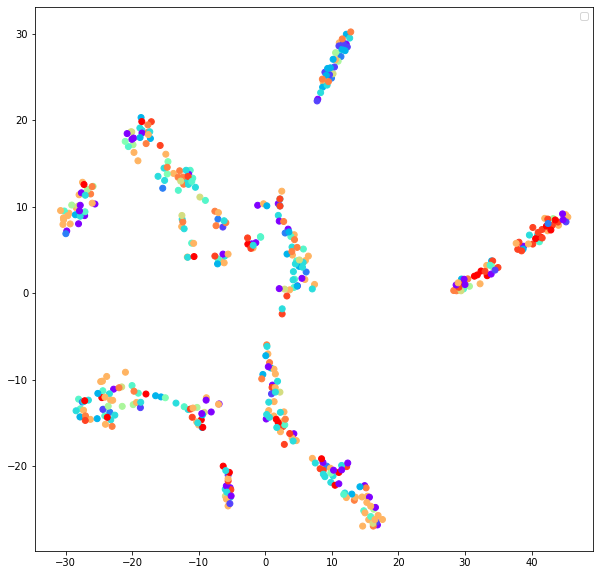

In [13]:
var_of_interest     = "Transcriptional_Identity"
trial, autoencoder, encoder = find_autoencoder(1)
coords  = encoder(gene_expression, training = False)
tSNE_plot(coords, var_of_interest)

In [132]:
@tf.function(experimental_relax_shapes=True)
def trainstep(model, x_train, optimizer):

    with tf.GradientTape() as tape:

        q       = model(x_train, training= True)
        p       = K.square(q) / K.sum(q, axis=0)
        p       = K.transpose( K.transpose(p) / K.sum(q, axis=1))
        loss    = K.sum(p*K.log(p/q))

    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    return loss

@tf.function(experimental_relax_shapes=True)
def teststep(model, x_test, optimizer):

    q       = model(x_test, training= False)
    p       = K.square(q) / K.sum(q, axis=0)
    p       = K.transpose( K.transpose(p) / K.sum(q, axis=1))
    loss    = K.sum(p*K.log(p/q))

    return loss

data        = gene_expression

encoder_cluster     = add_cluslayer(encoder, data, 13)

input_size  = data.shape[1]
encoder_2   = tf.keras.models.clone_model(encoder_cluster)
encoder_2.build(input_shape = (None, input_size))
encoder_2.set_weights(encoder_cluster.get_weights())
encoder_2.summary()

# encoder_2, train_loss, test_loss    = training(encoder_2, 1000)

# fig = plt.figure(figsize=(10,10))
# plt.plot(train_loss, label = 'train loss')
# plt.plot(test_loss, label = 'test loss')
# plt.legend()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoding_layer-1 (Dense)     (None, 97)                37054     
_________________________________________________________________
Dropout-1 (Dropout)          (None, 97)                0         
_________________________________________________________________
Encoding_layer-2 (Dense)     (None, 519)               50862     
_________________________________________________________________
Dropout-2 (Dropout)          (None, 519)               0         
_________________________________________________________________
Encoding_layer-3 (Dense)     (None, 1263)              656760    
_________________________________________________________________
Dropout-3 (Dropout)          (None, 1263)              0         
_________________________________________________________________
Encoding_layer-4 (Dense)     (None, 864)               1

# **Visualizing clusters**

In [15]:
encoder_3   = tf.keras.models.clone_model(encoder_2)
encoder_3.build(input_shape = (None, input_size))
encoder_3.set_weights(encoder_2.get_weights())